In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -r /content/drive/MyDrive/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
import os
from huggingface_hub import login

from google.colab import userdata  # to fetch secrets in Colab

# Load the Hugging Face token set in Colab Secrets
hf_token = userdata.get("HF_API_TOKEN")
if not hf_token:
    raise EnvironmentError("Hugging Face token not found in Colab Secrets.")

# Log in using the retrieved token (non-interactive and secure)
login(token=hf_token)


In [13]:
from transformers import pipeline
from langgraph.store.memory import InMemoryStore
from langgraph_bigtool.utils import convert_positional_only_function_to_tool
from langchain.embeddings import HuggingFaceEmbeddings  # Use Hugging Face embeddings
import math, types, uuid
from langgraph.store.memory import InMemoryStore

In [41]:
from langchain_mistralai.chat_models import ChatMistralAI

# Initialize the model
llm = ChatMistralAI(
    model="mistral-large-latest",  # Replace with your desired model
    temperature=0.7,
    max_retries=2,
)

In [95]:
# Initialize the HuggingFace embeddings model
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": False},
)

**Tool Loadout**

In [97]:
# Convert math functions into tools
all_tools = []
for name in dir(math):
    func = getattr(math, name)
    if isinstance(func, types.BuiltinFunctionType):
        if tool := convert_positional_only_function_to_tool(func):
            all_tools.append(tool)

tool_registry = {str(uuid.uuid4()): tool for tool in all_tools}

In [18]:
store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 384,  # MiniLM outputs 384-dimensional embeddings
        "fields": ["description"],
    }
)

for tool_id, tool in tool_registry.items():
    store.put(("tools",), tool_id, {"description": f"{tool.name}: {tool.description}"})

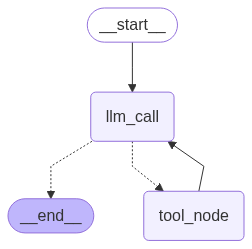

In [42]:
# Import organization: Type hints and third-party packages
from typing import Dict, Any
from typing_extensions import Literal

# LangChain core components
from langchain_core.messages import SystemMessage, ToolMessage, HumanMessage

# LangGraph components for workflow and state management
from langgraph.store.base import BaseStore
from langgraph.graph import END, START, StateGraph, MessagesState

# Jupyter display utilities
from IPython.display import Image, display

# Extended state class to store dynamically selected tools
class ToolLoadoutState(MessagesState):
    """State that extends MessagesState to include dynamically selected tools.

    This allows the agent to maintain context about which tools are currently
    available and bound to the conversation.
    """
    tools_by_name: Dict[str, Any] = {}

# System prompt defining the agent's role and capabilities
system_prompt = """You are a helpful assistant with access to mathematical functions from Python's math library.
You can search for and use relevant mathematical tools to solve problems.
When you need to perform mathematical calculations, first determine what type of mathematical operation you need,
then use the appropriate tools from the math library."""

def llm_call(state: ToolLoadoutState, store: BaseStore) -> dict:
    """Main LLM call that dynamically selects and binds relevant tools.

    This function implements the core tool loadout pattern:
    1. Extract query context from user message
    2. Search for semantically relevant tools
    3. Bind only relevant tools to the LLM
    4. Generate response with focused tool set

    Args:
        state: Current conversation state containing messages and tools
        store: Vector store containing indexed tool descriptions

    Returns:
        Dictionary with new messages and updated tool registry
    """
    # Extract user query for semantic tool search
    messages = state["messages"]
    if messages and isinstance(messages[-1], HumanMessage):
        query = messages[-1].content
    else:
        query = "mathematical calculation"  # Default fallback

    # Perform semantic similarity search to find relevant tools
    search_results = store.search(("tools",), query=query, limit=5)

    # Build focused tool set from search results
    relevant_tools = []
    tools_by_name = {}

    for result in search_results:
        tool_id = result.key
        if tool_id in tool_registry:
            tool = tool_registry[tool_id]
            relevant_tools.append(tool)
            tools_by_name[tool.name] = tool

    # Bind only relevant tools to avoid context overload
    llm_with_tools = llm.bind_tools(relevant_tools) if relevant_tools else llm

    # Generate response with focused context
    response = llm_with_tools.invoke(
        [SystemMessage(content=system_prompt)] + state["messages"]
    )

    return {
        "messages": [response],
        "tools_by_name": tools_by_name
    }

def tool_node(state: ToolLoadoutState) -> dict:
    """Execute tool calls using the dynamically selected tool set.

    Args:
        state: Current conversation state with tool calls

    Returns:
        Dictionary with tool execution results
    """
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        # Retrieve tool from the focused set stored in state
        tool = state["tools_by_name"][tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=str(observation), tool_call_id=tool_call["id"]))
    return {"messages": result}

def should_continue(state: ToolLoadoutState) -> Literal["tool_node", "__end__"]:
    """Determine workflow continuation based on tool calls.

    Args:
        state: Current conversation state

    Returns:
        Next node name or END
    """
    messages = state["messages"]
    last_message = messages[-1]

    # Continue to tool execution if LLM made tool calls
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise end the conversation
    return END

# Build the tool loadout workflow
agent_builder = StateGraph(ToolLoadoutState)

# Add workflow nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Define workflow edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node",
        END: END,
    },
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent with tool store for semantic search
agent = agent_builder.compile(store=store)

# Display the workflow graph
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [43]:
from rich.console import Console
from rich.panel import Panel
import json

console = Console()


def format_message_content(message):
    """Convert message content to displayable string"""
    if isinstance(message.content, str):
        return message.content
    elif isinstance(message.content, list):
        # Handle complex content like tool calls
        parts = []
        for item in message.content:
            if item.get('type') == 'text':
                parts.append(item['text'])
            elif item.get('type') == 'tool_use':
                parts.append(f"\n🔧 Tool Call: {item['name']}")
                parts.append(f"   Args: {json.dumps(item['input'], indent=2)}")
        return "\n".join(parts)
    else:
        return str(message.content)


def format_messages(messages):
    """Format and display a list of messages with Rich formatting"""
    for m in messages:
        msg_type = m.__class__.__name__.replace('Message', '')
        content = format_message_content(m)

        if msg_type == 'Human':
            console.print(Panel(content, title="🧑 Human", border_style="blue"))
        elif msg_type == 'Ai':
            console.print(Panel(content, title="🤖 Assistant", border_style="green"))
        elif msg_type == 'Tool':
            console.print(Panel(content, title="🔧 Tool Output", border_style="yellow"))
        else:
            console.print(Panel(content, title=f"📝 {msg_type}", border_style="white"))


def format_message(messages):
    """Alias for format_messages for backward compatibility"""
    return format_messages(messages)


def format_retriever_results(result, title="Retriever Tool Results"):
    """Format and display retriever tool results with proper text wrapping

    Args:
        result: List of documents from retriever tool or a string
        title: Title to display above the results
    """
    # Initialize console for rich formatting with width limit
    formatted_console = Console(width=100)

    formatted_console.print(f"[bold green]{title}:[/bold green]")

    # Handle case where result is a string
    if isinstance(result, str):
        formatted_console.print(f"\n[yellow]Content:[/yellow]")
        formatted_console.print(result, style="white")
        return

    # Handle case where result is a list of documents
    for i, doc in enumerate(result):
        formatted_console.print(f"\n[bold blue]Document {i+1}:[/bold blue]")

        # Check if doc has metadata attribute (Document object)
        if hasattr(doc, 'metadata'):
            formatted_console.print(f"[cyan]Source:[/cyan] {doc.metadata.get('source', 'Unknown')}")
            formatted_console.print(f"[yellow]Content:[/yellow]")
            formatted_console.print(doc.page_content, style="white")
        else:
            # Handle case where doc is just a string
            formatted_console.print(f"[yellow]Content:[/yellow]")
            formatted_console.print(str(doc), style="white")

In [44]:
from langchain_core.messages import HumanMessage

query = "Use available tools to calculate arc cosine of 0.5."
result = agent.invoke({"messages": [HumanMessage(content=query)]})
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Use available tools to calculate arc cosine of 0.5.                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To calculate the arc cosine of 0.5, we can use the `acos` function from Python's math library. This function    │
│ returns the arc cosine of a value in radians. Here's how we can do it:acos(0.5)The arc cosine of 0.5 is         │
│ approximately 1.0472 radians.                                                                                   │
│                                                                                                                 │
│ If you need the result in degrees, you can convert it using the `degrees` function from the math library. Would │
│ you like me to do that?                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

**Context** **Quarantine**

In [48]:
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor

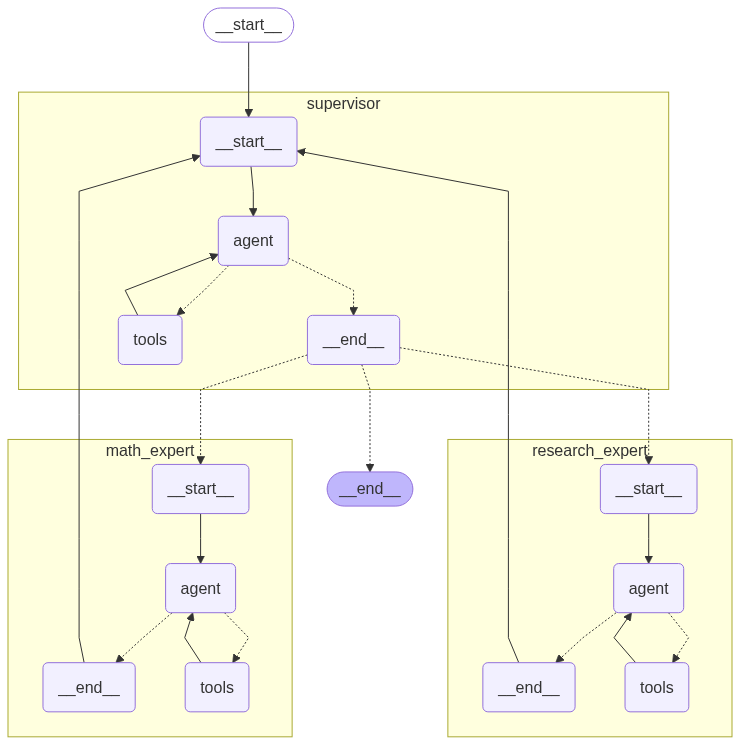

In [49]:
# Mathematical utility functions
def add(a: float, b: float) -> float:
    """Add two numbers.

    Args:
        a: First number to add
        b: Second number to add

    Returns:
        Sum of the two numbers
    """
    return a + b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers.

    Args:
        a: First number to multiply
        b: Second number to multiply

    Returns:
        Product of the two numbers
    """
    return a * b

# Mock data retrieval function
def web_search(query: str) -> str:
    """Mock web search function that returns FAANG company headcounts.

    In a real implementation, this would perform actual web searches.
    Currently returns static 2024 data for demonstration purposes.

    Args:
        query: Search query string (unused in this mock implementation)

    Returns:
        Formatted string with FAANG company employee headcounts
    """
    return (
        "Here are the headcounts for each of the FAANG companies in 2024:\n"
        "1. **Facebook (Meta)**: 67,317 employees.\n"
        "2. **Apple**: 164,000 employees.\n"
        "3. **Amazon**: 1,551,000 employees.\n"
        "4. **Netflix**: 14,000 employees.\n"
        "5. **Google (Alphabet)**: 181,269 employees."
    )

# Improved agent prompts with clear role definitions and constraints
math_agent = create_react_agent(
    model=llm,
    tools=[add, multiply],
    name="math_expert",
    prompt="""You are a specialized mathematics expert with access to addition and multiplication tools.

Your responsibilities:
- Solve mathematical problems using the available tools
- Always use tools for calculations rather than computing mentally
- Use one tool at a time and show your work clearly
- Focus exclusively on mathematical computations

Constraints:
- Do NOT attempt research, web searches, or data gathering
- Do NOT perform calculations without using the provided tools
- Always explain your mathematical reasoning step by step"""
)

research_agent = create_react_agent(
    model=llm,
    tools=[web_search],
    name="research_expert",
    prompt="""You are a specialized research expert with access to web search capabilities.

Your responsibilities:
- Find and retrieve factual information using web search
- Provide comprehensive, well-sourced answers to research questions
- Focus on data gathering and information synthesis

Constraints:
- Do NOT perform mathematical calculations or computations
- Do NOT attempt to solve math problems - delegate those to the math expert
- Always use your search tool to find current, accurate information
- Present findings clearly and cite sources when available"""
)

# Enhanced supervisor prompt with clear delegation strategy
supervisor_prompt = """You are an intelligent team supervisor managing two specialized experts: a research expert and a math expert.

Your role is to:
1. Analyze incoming requests to determine the required expertise
2. Delegate tasks to the appropriate specialist
3. Coordinate between agents when tasks require multiple skills
4. Synthesize results from multiple agents when necessary

Delegation Rules:
- For data gathering, company information, current events, or factual research → use research_agent
- For calculations, mathematical operations, or numerical analysis → use math_agent
- For complex tasks requiring both research and math → delegate sequentially (research first, then math)

Important: You are a coordinator, not a doer. Always delegate work to your specialists rather than attempting tasks yourself. Never perform calculations or research directly."""

# Create supervisor workflow for coordinating agents
workflow = create_supervisor(
    [research_agent, math_agent],
    model=llm,
    prompt=supervisor_prompt
)

# Compile the multi-agent application
app = workflow.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [50]:
query = "what's the combined headcount of the FAANG companies in 2024?"
result = app.invoke({"messages": [{"role": "user", "content": query}]})
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ what's the combined headcount of the FAANG companies in 2024?                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Successfully transferred to research_expert                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on the data retrieved, here are the headcounts for each of the FAANG companies in 2024:                   │
│                                                                                                                 │
│ - Facebook (Meta): 67,317 employees                                                                             │
│ - Apple: 164,000 employees                                                                                      │
│ - Amazon: 1,551,000 employees                                                                                   │
│ - Netflix: 14,000 employees                                                                                     │
│ - Google (Alphabet): 181,269 employees                                                                          │
│                                                                                                                 │
│ Could you please calculate the combined headcount of these FAANG companies?                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Transferring back to supervisor                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Successfully transferred back to supervisor                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Successfully transferred to math_expert                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The combined headcount of the FAANG companies in 2024 is 1,977,586 employees.                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Transferring back to supervisor                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Successfully transferred back to supervisor                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The combined headcount of the FAANG companies in 2024 is 1,977,586 employees.                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

**Context Pruning**

In [51]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2025-05-01-thinking/",
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [52]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=3000, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [53]:
from langchain_core.vectorstores import InMemoryVectorStore
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=embeddings
)
retriever = vectorstore.as_retriever()

In [54]:
from langchain.tools.retriever import create_retriever_tool
from rich.console import Console
from rich.pretty import pprint

# Initialize console for rich formatting
console = Console()

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

result = retriever_tool.invoke({"query": "types of reward hacking"})
console.print("[bold green]Retriever Tool Results:[/bold green]")
pprint(result)

Retriever Tool Results:

'Reward Hacking in Reinforcement Learning | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nData Analysis of RLHF\n\n\nCitation\n\nReferences\n\n\n\n\n\nReward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use cases of AI models.\nMost of the past work on this topic has been quite theoretical and focused on defining or demonstrating the existence of reward hacking. However, research into practical mitigations, especially in the context of RLHF and LLMs, remains limited. I especially want to call out for more research efforts directed toward understanding and developing mitigation for reward hacking in the future. Hope I will be able to cover the mitigation part in a dedicated post soon.\nBackground#\nReward Function in RL#\nReward function defines the task, and reward shaping significantly impacts learning efficiency and accuracy in reinforcement learning. Designing a reward function for an RL task often feels like a ‘dark art’. Many factors contribute to this complexity: How you decompose a big goal into small goals? Is the reward sparse or dense? How you measure the success? Various choices may lead to good or problematic learning dynamics, including unlearnable tasks or hackable reward functions. There is a long history of research on how to do reward shaping in RL.\nFor example, in an 1999 paper by Ng et al., the authors studied how to modify the reward function in Markov Decision Processes (MDPs) such that the optimal policy remains unchanged. They found that linear transformation works. Given a MDP $M = (S, A, T, \\gamma, R)$, we want to create a transformed MDP $M’ = (S, A, T, \\gamma, R’)$ where $R’ = R + F$ and $F: S \\times A \\times S \\mapsto \\mathbb{R}$, such that we can guide the learning algorithm to be more efficient. Given a real-valued function $\\Phi: S \\mapsto \\mathbb{R}$, $F$ is a potential-based shaping function if for all $s \\in S - {s_0}, a \\in A, s’ \\in S$:\n\n$$\nF(s, a, s\') = \\gamma \\Phi(s\') - \\Phi(s)\n$$\n\nThis would guarantee that the sum of discounted $F$, $F(s_1, a_1, s_2) + \\gamma F(s_2, a_2, s_3) + \\dots$, ends up being 0. If $F$ is such a potential-based shaping function, it is both sufficient and necessary to ensure $M$ and $M’$ share the same optimal policies.\nWhen $F(s, a, s’) = \\gamma \\Phi(s’) - \\Phi(s)$, and if we further assume that $\\Phi(s_0) 

In [55]:
# Set up tools and bind them to the LLM
tools = [retriever_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Bind tools to LLM for agent functionality
llm_with_tools = llm.bind_tools(tools)

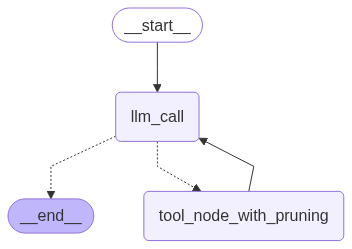

In [58]:
from typing_extensions import Literal

from IPython.display import Image, display
from langchain_core.messages import SystemMessage, ToolMessage
from langgraph.graph import END, START, MessagesState, StateGraph

# Define extended state with summary field
class State(MessagesState):
    """Extended state that includes a summary field for context compression."""
    summary: str

# Define the RAG agent system prompt
rag_prompt = """You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng.
Clarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and
proceed until you have sufficient context to answer the user's research request."""

def llm_call(state: MessagesState) -> dict:
    """Execute LLM call with system prompt and message history.

    This function demonstrates context pruning by trimming messages to fit within
    token limits while maintaining conversation coherence.

    Args:
        state: Current conversation state

    Returns:
        Dictionary with new messages
    """
    # Add system prompt to the trimmed messages
    messages = [SystemMessage(content=rag_prompt)] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Improved prompt for context pruning
tool_pruning_prompt = """You are an expert at extracting relevant information from documents.

Your task: Analyze the provided document and extract ONLY the information that directly answers or supports the user's specific request. Remove all irrelevant content.

User's Request: {initial_request}

Instructions for pruning:
1. Keep information that directly addresses the user's question
2. Preserve key facts, data, and examples that support the answer
3. Remove tangential discussions, unrelated topics, and excessive background
4. Maintain the logical flow and context of relevant information
5. If multiple subtopics are discussed, focus only on those relevant to the request
6. Preserve important quotes, statistics, and research findings when relevant

Return the pruned content in a clear, concise format that maintains readability while focusing solely on what's needed to answer the user's request."""

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: State) -> Literal["tool_node_with_pruning", "__end__"]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""
    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node_with_pruning"

    # Otherwise, we stop (reply to the user)
    return END

def tool_node_with_pruning(state: State):
    """Performs the tool call with context pruning"""
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])

        initial_request = state['messages'][0].content

        # Prune the document content to focus on user's request
        summarization_llm = llm
        pruned_content = summarization_llm.invoke([
            {"role": "system", "content": tool_pruning_prompt.format(initial_request=initial_request)},
            {"role": "user", "content": observation}
        ])

        result.append(ToolMessage(content=pruned_content.content, tool_call_id=tool_call["id"]))

    return {"messages": result}

# Build workflow
agent_builder = StateGraph(State)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node_with_pruning", tool_node_with_pruning)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node_with_pruning": "tool_node_with_pruning",
        END: END,
    },
)
agent_builder.add_edge("tool_node_with_pruning", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [59]:
query = "What are the types of reward hacking discussed in the blogs?"
result = agent.invoke({"messages": [{"role": "user", "content": query}]})
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What are the types of reward hacking discussed in the blogs?                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The types of reward hacking discussed in the blogs are:                                                         │
│                                                                                                                 │
│ 1. **Reward Hacking**: Exploiting flaws or ambiguities in the reward function to achieve high rewards without   │
│ genuinely learning the intended task.                                                                           │
│ 2. **Reward Corruption**: Manipulating the reward function or its implementation to achieve high rewards.       │
│ 3. **Reward Tampering**: Interfering with the reward mechanism itself, causing the observed reward to no longer │
│ accurately represent the intended goal.                                                                         │
│ 4. **Specification Gaming**: Satisfying the literal specification of an objective but not achieving the desired │
│ results.                                                                                                        │
│ 5. **Objective Robustness/Goal Misgeneralization**: The model generalizes capably but pursues an objective      │
│ different from the one it was trained on due to a mismatch between the proxy reward and the true reward         │
│ function.                                                                                                       │
│ 6. **In-Context Reward Hacking**: Reward hacking behavior that emerges within the context of a specific task or │
│ environment, often due to the model's interaction with that context.                                            │
│                                                                                                                 │
│ These types of reward hacking highlight the various ways in which reinforcement learning agents can exploit or  │
│ manipulate reward functions to achieve high rewards without genuinely learning or completing the intended task. │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The types of reward hacking discussed in the blogs are:                                                         │
│                                                                                                                 │
│ 1. Reward Hacking                                                                                               │
│ 2. Reward Corruption                                                                                            │
│ 3. Reward Tampering                                                                                             │
│ 4. Specification Gaming                                                                                         │
│ 5. Objective Robustness/Goal Misgeneralization                                                                  │
│ 6. In-Context Reward Hacking                                                                                    │
│                                                                                                                 │
│ Is there something else I can help you with?                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

**Context Summarization**

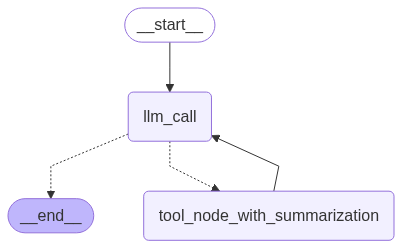

In [62]:
# Import organization and workflow setup
from typing_extensions import Literal
from IPython.display import Image, display

from langchain_core.messages import SystemMessage, ToolMessage
from langgraph.graph import END, START, MessagesState, StateGraph

# Define extended state with summary field for context compression
class State(MessagesState):
    """Extended state that includes a summary field for context compression."""
    summary: str

# Define the RAG agent system prompt
rag_prompt = """You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng.
Clarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and
proceed until you have sufficient context to answer the user's research request."""

def llm_call(state: State) -> dict:
    """Execute LLM call with system prompt and message history.

    Args:
        state: Current conversation state

    Returns:
        Dictionary with new messages
    """
    messages = [SystemMessage(content=rag_prompt)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Updated summarization prompt to avoid encouraging further searches
tool_summarization_prompt = """You are an expert at condensing technical documents while preserving all critical information.

Transform the provided document into a comprehensive yet concise version. Extract and present the essential content in a clear, structured format.

Condensation Guidelines:
1. **Preserve All Key Information**: Include every important fact, statistic, finding, and conclusion
2. **Eliminate Verbosity**: Remove repetitive text, excessive explanations, and filler words
3. **Maintain Logical Structure**: Keep the natural flow and relationships between concepts
4. **Use Precise Language**: Replace lengthy phrases with direct, technical terminology
5. **Ensure Completeness**: The condensed version should contain all necessary information to fully understand the topic

Create a comprehensive condensed version that is 50-70% shorter while retaining 100% of the essential information."""

def should_continue(state: State) -> Literal["tool_node_with_summarization", "__end__"]:
    """Determine next step based on whether LLM made tool calls.

    Args:
        state: Current conversation state

    Returns:
        Next node to execute or END
    """
    messages = state["messages"]
    last_message = messages[-1]

    # If LLM made tool calls, process them with summarization
    if last_message.tool_calls:
        return "tool_node_with_summarization"

    # Otherwise, end the conversation
    return END

def tool_node_with_summarization(state: State):
    """Execute tool calls and summarize results for context efficiency.

    Args:
        state: Current conversation state with tool calls

    Returns:
        Dictionary with summarized tool results
    """
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        # Execute the tool
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])

        # Summarize the tool output to reduce context size
        summarization_llm = llm
        condensed_content = summarization_llm.invoke([
            {"role": "system", "content": tool_summarization_prompt},
            {"role": "user", "content": observation}
        ])

        result.append(ToolMessage(content=condensed_content.content, tool_call_id=tool_call["id"]))

    return {"messages": result}

# Build the RAG agent workflow with summarization
agent_builder = StateGraph(State)

# Add workflow nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node_with_summarization", tool_node_with_summarization)

# Define workflow edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node_with_summarization": "tool_node_with_summarization",
        END: END,
    },
)
agent_builder.add_edge("tool_node_with_summarization", "llm_call")

# Compile and display the agent
agent = agent_builder.compile()
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [63]:
query = "What are the types of reward hacking discussed in the blogs?"
result = agent.invoke({"messages": query})
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What are the types of reward hacking discussed in the blogs?                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # Condensed Version: Reward Hacking in Reinforcement Learning                                                   │
│                                                                                                                 │
│ ## Background                                                                                                   │
│                                                                                                                 │
│ ### Reward Function in RL                                                                                       │
│ - **Reward shaping** significantly impacts learning efficiency and accuracy in RL.                              │
│ - **Challenges**: Decomposing goals, sparse vs. dense rewards, measuring success.                               │
│ - **Potential-based shaping function** (Ng et al., 1999): Modifies reward function while keeping optimal policy │
│ unchanged.                                                                                                      │
│   - \( F(s, a, s') = \gamma \Phi(s') - \Phi(s) \)                                                               │
│   - Ensures \( M \) and \( M' \) share the same optimal policies.                                               │
│                                                                                                                 │
│ ### Spurious Correlation                                                                                        │
│ - **Shortcut learning**: Models overfit to spurious features, failing to generalize.                            │
│ - **Example**: Classifier distinguishing wolves from huskies may overfit to snowy backgrounds.                  │
│ - **ERM principle**: Minimizing training loss can lead to reliance on spurious features.                        │
│                                                                                                                 │
│ ## Reward Hacking                                                                                               │
│                                                                                                                 │
│ ### Definition                                                                                                  │
│ - **Reward hacking**: Exploiting flaws in reward functions to achieve high rewards without completing the       │
│ intended task.                                                                                                  │
│ - **Related concepts**: Reward corruption, reward tampering, specification gaming, objective robustness, goal   │
│ misgeneralization, reward misspecifications.                                                                    │
│                                                                                                                 │
│ ### Examples                                                                                                    │
│ - **RL tasks**: Robot hand tricking camera, agent exploiting physics simulator bugs, agent circling around a    │
│ goal.                                                                                                           │
│ - **LLM tasks**: Model changing unit tests to pass coding tasks, exploiting ROUGE metric flaws.                 │
│ - **Real life**: Social media algorithms recommending extreme content for engagement, financial crisis due to   │
│ gaming the system.                                                                                              │
│                                                                                                                 │
│ ## Why Reward Hacking Exists                                                                                    │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The types of reward hacking discussed in the blog post are:                                                     │
│                                                                                                                 │
│ 1. **Reward Corruption**: Manipulating the reward function itself to achieve higher rewards without fulfilling  │
│ the intended task.                                                                                              │
│ 2. **Reward Tampering**: Directly altering the reward signals to deceive the learning system.                   │
│ 3. **Specification Gaming**: Exploiting loopholes or ambiguities in the reward function's specification to      │
│ achieve high rewards in unintended ways.                                                                        │
│ 4. **Objective Robustness Issues**: Challenges arising from the lack of robustness in the defined objectives,   │
│ leading to exploitation.                                                                                        │
│ 5. **Goal Misgeneralization**: The model achieving high rewards by misinterpreting the goal due to flawed       │
│ reward functions.                                                                                               │
│ 6. **Reward Misspecifications**: Errors or inaccuracies in the definition of the reward function that lead to   │
│ unintended behaviors.                                                                                           │
│                                                                                                                 │
│ These types highlight various ways in which the reward system can be exploited or manipulated, leading to       │
│ behaviors that do not align with the intended objectives.                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

**Context Offloading**

In [98]:
from pydantic import BaseModel, Field
from typing_extensions import Literal
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_mistralai import ChatMistralAI
from langgraph.graph import StateGraph, START, END, MessagesState
from IPython.display import Image, display
import os, getpass

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key:\n")

# Extended state with scratchpad
class ScratchpadState(MessagesState):
    scratchpad: str = Field("", description= "Notes storage across conversation")

# Define scratchpad tools
from langchain_core.tools import tool

@tool
class WriteToScratchpad(BaseModel):
    notes: str = Field(..., description="Notes to save to scratchpad")

@tool
class ReadFromScratchpad(BaseModel):
    reasoning: str = Field(..., description="Reasoning to fetch notes")

# Placeholder for TavilySearch tool setup
from langchain_tavily import TavilySearch
search_tool = TavilySearch(max_results=5, topic="general")

tools = [WriteToScratchpad, ReadFromScratchpad, search_tool]
tools_by_name = {t.name: t for t in tools}

# Initialize Mistral LLM with tools bound
llm = ChatMistralAI(model="mistral-large-latest", temperature=0)
llm_with_tools = llm.bind_tools(tools)


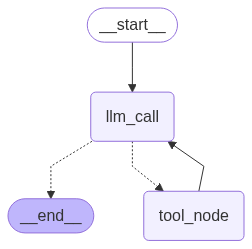

In [86]:
system_prompt = """
You are a research assistant with web search and a scratchpad for note-taking...
"""

def llm_call(state: ScratchpadState) -> dict:
    return {
        "messages": [
            llm_with_tools.invoke([SystemMessage(content=system_prompt)] + state["messages"])
        ]
    }

def tool_node(state: ScratchpadState) -> dict:
    result = []
    last = state["messages"][-1]
    for call in getattr(last, "tool_calls", []):
        tool = tools_by_name[call["name"]]
        obs = tool.invoke(call["args"])

        if call["name"] == "WriteToScratchpad":
            state["scratchpad"] = obs.notes
            result.append(ToolMessage(content=f"Wrote: {obs.notes}", tool_call_id=call["id"]))
        elif call["name"] == "ReadFromScratchpad":
            notes = state.get("scratchpad", "")
            result.append(ToolMessage(content=f"Notes: {notes}", tool_call_id=call["id"]))
        else:
            result.append(ToolMessage(content=str(obs), tool_call_id=call["id"]))

    return {"messages": result}

def should_continue(state: ScratchpadState) -> Literal["tool_node", "__end__"]:
    last = state["messages"][-1]
    return "tool_node" if getattr(last, "tool_calls", None) else END

# Build LangGraph agent
agent_builder = StateGraph(ScratchpadState)
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges("llm_call", should_continue, {"tool_node": "tool_node", END: END})
agent_builder.add_edge("tool_node", "llm_call")
agent = agent_builder.compile()

# Show the graph
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))


In [92]:
from google.colab import userdata
import os

# Retrieve the API key from Colab's secret management
api_key = userdata.get('TAVILY_API_KEY')

# Set the environment variable
os.environ['TAVILY_API_KEY'] = api_key

# Initialize Tavily client
from tavily import TavilyClient
tavily_client = TavilyClient(api_key=api_key)

In [93]:
# Research request
from langchain_core.messages import HumanMessage
query = "Comparae the funding rounds and recent developments of Commonwealth Fusion Systems vs Helion Energy."
state = agent.invoke({"messages": [HumanMessage(content=query)]})
format_messages(state['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Comparae the funding rounds and recent developments of Commonwealth Fusion Systems vs Helion Energy.            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'error': ValueError('Error 401: Unauthorized: missing or invalid API key.')}                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'error': ValueError('Error 401: Unauthorized: missing or invalid API key.')}                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'm sorry, but I currently don't have the capability to access the tools needed to provide an answer to your    │
│ question. If you have any other questions or need assistance with something else, feel free to ask!             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯